# Gibbs sampling for joint inference of transmission network and infection times

Sergio Bacallado, 3/6/2020

In [646]:
import numpy as np
from scipy.stats import gamma
import scipy
import copy
import cPickle

In [549]:
class Tree:
    """Represents a tree rooted at 0 where each node's parent is constrained
    to be in some set. Cases adjacent to the root are index cases.
    
    """
    def __init__(self,n,possibleParents):
        self.n = n # Number of nodes (not including root)
        self.possibleParents = possibleParents # A dict of possible parents for each node
        self.Initialise()
        
    def Reset(self):
        """Generates the data structures for parent, child.
        
        """
        self.parent = {i: 0 for i in range(1,self.n+1)}
        self.child = {i: set() for i in range(self.n+1)}
        self.descendant = {i: set() for i in range(self.n+1)}
    
    def AssignNodes(self):
        growth = 1
        while growth > 0:
            bef = len(self.assigned)
            for v in set(range(1,self.n+1)).difference(self.assigned):
                parentsAssigned =  set(self.possibleParents[v]).intersection(self.assigned)
                if len(parentsAssigned)>0:
                    w = np.random.choice(list(parentsAssigned))
                    self.parent[v] = w
                    self.child[w].add(v)
                    self.assigned.add(v)
            growth = len(self.assigned)-bef
    
    def Initialise(self):
        """ Initialises the infection network such that there are no cycles.
        
        """
        x = np.random.permutation(self.n)
        self.Reset()
        self.assigned = set()
        # Add all the sure index cases to assigned
        for v in range(1,self.n+1):
            if len(self.possibleParents[v])==1 and (0 in self.possibleParents[v]):
                self.parent[v] = 0
                self.child[0].add(v)
                self.assigned.add(v)
        # Assign parents to cases iteratively from those already assigned
        self.AssignNodes()
        while len(self.assigned)<self.n:
            v = np.random.choice(list(set(range(1,self.n+1)).difference(self.assigned)))
            self.parent[v] = 0
            self.child[0].add(v)
            self.assigned.add(v)
            self.AssignNodes()
        self.ComputeDescendants()
        if self.HasCycle():
            print("Failed to build a tree!")
    
    def ComputeDescendants(self,v=0):
        """ From the parents and children dictionaries, compute descendant diccionary
        for a given node v.
        
        """
        self.descendant[v] = set()
        for c in self.child[v]:
            self.descendant[v].add(c)
            self.descendant[v].update(self.ComputeDescendants(c))
        return self.descendant[v]
            
    def HasCycle(self):
        """Checks if directed graph structure in self.parent has cycle.
        
        """
        if self.parent=={}:
            return True
        for v in xrange(self.n+1):
            if not self.GetsTo(v,0)[0]:
                return True
        return False
    
    def GetsTo(self,v,w,k=None):
        """Checks whether there is a directed path from v to w of length<=k, outputs 
        True or False, and if true, the distance between the nodes.
        
        """
        if k == None:
            k = self.n+2
        if v == w:
            return (True, 0)
        if k == 0:
            return (False, None)
        x,y = self.GetsTo(self.parent[v],w,k-1)
        return ((x,y+1) if x else (x,None)) 
    
    
    def AllowedParents(self,v):
        """ Returns possible parents of v who are not currently descendants of v.
        
        """
        return set(self.possibleParents[v]).difference(self.descendant[v])
    
    def ProposeMove(self):
        """Proposes a move to a new tree by reassigning the parent of one node uniformly
        at random. Returns the new tree, the ratio of probabilities of the forward and 
        backward moves, the node changing parents, and the two parents.
        
        """
        moveableNode = np.arange(1,self.n+1)
        moveableNode = moveableNode[[len(self.possibleParents[v])>1 for v in moveableNode]]
        allowedParents = set()
        while len(allowedParents)<2:
            v = np.random.choice(moveableNode)
            allowedParents = self.AllowedParents(v)
        oldPa = self.parent[v]
        newPa = np.random.choice(list(allowedParents.difference([oldPa])))
        newT = copy.deepcopy(self)
        newT.parent[v] = newPa
        newT.child[oldPa].remove(v)
        newT.child[newPa].add(v) 
        newT.ComputeDescendants()
        ratio = float(len(newT.AllowedParents(v))-1)/float(len(allowedParents)-1)
        return newT, ratio, v, self.parent[v], newT.parent[v]
    
    def Level(self,v):
        """ Returns the distance from v to root 0.
        
        """
        return self.GetsTo(v,0)[1]

In [550]:
class Params:
    def __init__(self,a1,b1,a2,b2):
        self.a1 = a1
        self.b1 = b1
        self.a2 = a2
        self.b2 = b2

In [551]:
def OrderViolated(S,I,T):
    """ Check whether the order of infection and symptom onset is violated in the
    triple S,I,T.
    
    """
    for v in range(1,n+1):
        if min([S[v]]+[S[w]-1 for w in T.child[v]]) - I[T.parent[v]] < 2:
            return True,v
    return False,-1

def InitialiseI(S,I,T):
    """ Initialises the infection times I given symptom onset S and tree T.
    
    """
    for v in range(1,n+1):
        I[v] = min([S[v]]+[S[w]-1 for w in T.child[v]]) - 1
    cond,v = OrderViolated(S,I,T)
    while cond:
        I[T.parent[v]] += -1
        cond,v = OrderViolated(S,I,T)

In [605]:
def GibbsSampler(T,I,params,S,nIter,saveInt,maxTime=30):
    n = T.n
    samples = []
    for i in xrange(nIter):
        print("Iteration %i"%i)
        # Determine nodes an even or odd distance from 0
        levels = np.array([T.Level(v) for v in range(n+1)])  # Get level for each node
        oddLevels = (levels%2==1)
        evenLevels = (levels%2==0)
        #print S-I
        # Update I_v for odd nodes
        post = GetPost(T,I,params,S,maxTime)
        newI = (post.cumsum(0) < np.random.rand(post.shape[1])).argmin(0)
        I[oddLevels] = newI[oddLevels]
        # Update I_v for even nodes
        post = GetPost(T,I,params,S,maxTime)  
        newI = (post.cumsum(0) < np.random.rand(post.shape[1])).argmin(0)
        I[evenLevels] = newI[evenLevels]
        # Resample tree
        for _ in xrange(10):
            newT,ratio,v,w1,w2 = T.ProposeMove()
            if I[v]-I[w2] < 0:    # Don't accept moves that have parent infected before child
                continue
            acc = np.exp(LogGenerationLik(I[v]-I[w2],params)-LogGenerationLik(I[v]-I[w1],params))/ratio
            if np.random.rand() < acc:
                T = newT
                #print("accepted")
        # Update parameters
        for _ in xrange(10):
            params = UpdateParams(T,I,S,params)
        # Trace sample
        if i%saveInt==1:
            samples.append([T,I,params])
    return samples
        
def LogGenerationLik(x,params):
    return gamma.logpdf(x,params.a1,scale=1/params.b1)
    
def LogIncubationLik(x,params):
    return gamma.logpdf(x,params.a2,scale=1/params.b2)
    
def UpdateParams(T,I,S,params):
    """ Metropolis-Hastings step for the parameters.
    
    """
    scale = 0.3
    newParams = copy.deepcopy(params)
    newParams.a1 = params.a1 + scale * (np.random.rand() -0.5)
    newParams.b1 = params.b1 + scale * (np.random.rand() -0.5)
    if (newParams.a1 < 0) or (newParams.b1 < 0):
        return params
    notIndex = np.array([False]+[T.parent[v]!=0 for v in range(1,T.n)])
    genInts = [I[v]-I[T.parent[v]] for v in np.arange(T.n)[notIndex]]
    acc = sum(LogGenerationLik(genInts,newParams))
    acc += -sum(LogGenerationLik(genInts,params))
    if np.random.rand() < np.exp(acc):
        #print("accepted params")
        return newParams
    else:
        return params
    
def LogPostForI(v,t,T,I,params,S):
    return LogIncubationLik(S[v]-t,params) \
            + (LogGenerationLik(t-I[T.parent[v]],params) if T.parent[v]!=0 else 0.0 ) \
            + sum(LogGenerationLik(I[w]-t,params) for w in T.child[v])
    
def GetPost(T,I,params,S,maxTime=30):
    """ Outputs a (maxTime x n+1) array storing for each node v (column), 
    the factors of the posterior depending on I[v], for every possible
    assignment of I[v] (row).
    
    """
    logpost = np.zeros((T.n+1,maxTime))
    logpost[1:,:] = -np.inf
    for v in xrange(1,T.n+1):
        t1 = I[T.parent[v]] if T.parent[v] != 0 else -1
        t2 = min([S[v]]+[I[w] for w in T.child[v]]) 
        for t in xrange(int(t1)+1,int(t2)):
            logpost[v,t] = LogPostForI(v,t,T,I,params,S) 
    logpost = np.transpose(logpost)
    #print logpost.max(0)
    logpost += -logpost.max(0)
    post = np.exp(logpost)
    return post/post.sum(0)

## Run MCMC chain

In [606]:
np.random.seed(1)

possibleInfector = np.genfromtxt("PossibleInfector.csv",delimiter=",",dtype=int)
S = np.loadtxt("SymptonOnsetTimes.csv",skiprows=1)

n = possibleInfector.shape[0]
# Fix mistake in dataset: Cases 40,41,42 don't have a possible parent outside the set {40,41,42}, 
# so they always form a cycle. We add the possibility that each of them is an index case.
possibleInfector[39,3] = 0
possibleInfector[40,3] = 0
possibleInfector[41,3] = 0
possibleParents = {i+1: possibleInfector[i,~(possibleInfector[i,:]==-1)] for i in range(n)}
T = Tree(n,possibleParents)
S = S+14                           # Shift symptom onset times so that the first patient shows symptoms on day 14
                                   # we'll consider the earliest possible infection time to be 0.
maxTime = int(max(S))              # The maximum infection time will be the maximum symptom onset time
I = np.zeros(n+1)                  # Length of S and I should be n+1, first element in each is irrelevant
S = np.concatenate([np.zeros(1),S])
# Initialise infection times  
InitialiseI(S,I,T)
# Initialise parameters
params = Params(3.45,0.66,3.45,0.66)

In [607]:
#%%timeit -n 1 -r 1
samples = GibbsSampler(T,I,params,S,3000,10,maxTime)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

Iteration 594
Iteration 595
Iteration 596
Iteration 597
Iteration 598
Iteration 599
Iteration 600
Iteration 601
Iteration 602
Iteration 603
Iteration 604
Iteration 605
Iteration 606
Iteration 607
Iteration 608
Iteration 609
Iteration 610
Iteration 611
Iteration 612
Iteration 613
Iteration 614
Iteration 615
Iteration 616
Iteration 617
Iteration 618
Iteration 619
Iteration 620
Iteration 621
Iteration 622
Iteration 623
Iteration 624
Iteration 625
Iteration 626
Iteration 627
Iteration 628
Iteration 629
Iteration 630
Iteration 631
Iteration 632
Iteration 633
Iteration 634
Iteration 635
Iteration 636
Iteration 637
Iteration 638
Iteration 639
Iteration 640
Iteration 641
Iteration 642
Iteration 643
Iteration 644
Iteration 645
Iteration 646
Iteration 647
Iteration 648
Iteration 649
Iteration 650
Iteration 651
Iteration 652
Iteration 653
Iteration 654
Iteration 655
Iteration 656
Iteration 657
Iteration 658
Iteration 659
Iteration 660
Iteration 661
Iteration 662
Iteration 663
Iteration 664
Iterat

/Users/sergiob/opt/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


Iteration 686
Iteration 687
Iteration 688
Iteration 689
Iteration 690
Iteration 691
Iteration 692
Iteration 693
Iteration 694
Iteration 695
Iteration 696
Iteration 697
Iteration 698
Iteration 699
Iteration 700
Iteration 701
Iteration 702
Iteration 703
Iteration 704
Iteration 705
Iteration 706
Iteration 707
Iteration 708
Iteration 709
Iteration 710
Iteration 711
Iteration 712
Iteration 713
Iteration 714
Iteration 715
Iteration 716
Iteration 717
Iteration 718
Iteration 719
Iteration 720
Iteration 721
Iteration 722
Iteration 723
Iteration 724
Iteration 725
Iteration 726
Iteration 727
Iteration 728
Iteration 729
Iteration 730
Iteration 731
Iteration 732
Iteration 733
Iteration 734
Iteration 735
Iteration 736
Iteration 737
Iteration 738
Iteration 739
Iteration 740
Iteration 741
Iteration 742
Iteration 743
Iteration 744
Iteration 745
Iteration 746
Iteration 747
Iteration 748
Iteration 749
Iteration 750
Iteration 751
Iteration 752
Iteration 753
Iteration 754
Iteration 755
Iteration 756
Iterat

Iteration 1254
Iteration 1255
Iteration 1256
Iteration 1257
Iteration 1258
Iteration 1259
Iteration 1260
Iteration 1261
Iteration 1262
Iteration 1263
Iteration 1264
Iteration 1265
Iteration 1266
Iteration 1267
Iteration 1268
Iteration 1269
Iteration 1270
Iteration 1271
Iteration 1272
Iteration 1273
Iteration 1274
Iteration 1275
Iteration 1276
Iteration 1277
Iteration 1278
Iteration 1279
Iteration 1280
Iteration 1281
Iteration 1282
Iteration 1283
Iteration 1284
Iteration 1285
Iteration 1286
Iteration 1287
Iteration 1288
Iteration 1289
Iteration 1290
Iteration 1291
Iteration 1292
Iteration 1293
Iteration 1294
Iteration 1295
Iteration 1296
Iteration 1297
Iteration 1298
Iteration 1299
Iteration 1300
Iteration 1301
Iteration 1302
Iteration 1303
Iteration 1304
Iteration 1305
Iteration 1306
Iteration 1307
Iteration 1308
Iteration 1309
Iteration 1310
Iteration 1311
Iteration 1312
Iteration 1313
Iteration 1314
Iteration 1315
Iteration 1316
Iteration 1317
Iteration 1318
Iteration 1319
Iteration 

Iteration 1801
Iteration 1802
Iteration 1803
Iteration 1804
Iteration 1805
Iteration 1806
Iteration 1807
Iteration 1808
Iteration 1809
Iteration 1810
Iteration 1811
Iteration 1812
Iteration 1813
Iteration 1814
Iteration 1815
Iteration 1816
Iteration 1817
Iteration 1818
Iteration 1819
Iteration 1820
Iteration 1821
Iteration 1822
Iteration 1823
Iteration 1824
Iteration 1825
Iteration 1826
Iteration 1827
Iteration 1828
Iteration 1829
Iteration 1830
Iteration 1831
Iteration 1832
Iteration 1833
Iteration 1834
Iteration 1835
Iteration 1836
Iteration 1837
Iteration 1838
Iteration 1839
Iteration 1840
Iteration 1841
Iteration 1842
Iteration 1843
Iteration 1844
Iteration 1845
Iteration 1846
Iteration 1847
Iteration 1848
Iteration 1849
Iteration 1850
Iteration 1851
Iteration 1852
Iteration 1853
Iteration 1854
Iteration 1855
Iteration 1856
Iteration 1857
Iteration 1858
Iteration 1859
Iteration 1860
Iteration 1861
Iteration 1862
Iteration 1863
Iteration 1864
Iteration 1865
Iteration 1866
Iteration 

Iteration 2348
Iteration 2349
Iteration 2350
Iteration 2351
Iteration 2352
Iteration 2353
Iteration 2354
Iteration 2355
Iteration 2356
Iteration 2357
Iteration 2358
Iteration 2359
Iteration 2360
Iteration 2361
Iteration 2362
Iteration 2363
Iteration 2364
Iteration 2365
Iteration 2366
Iteration 2367
Iteration 2368
Iteration 2369
Iteration 2370
Iteration 2371
Iteration 2372
Iteration 2373
Iteration 2374
Iteration 2375
Iteration 2376
Iteration 2377
Iteration 2378
Iteration 2379
Iteration 2380
Iteration 2381
Iteration 2382
Iteration 2383
Iteration 2384
Iteration 2385
Iteration 2386
Iteration 2387
Iteration 2388
Iteration 2389
Iteration 2390
Iteration 2391
Iteration 2392
Iteration 2393
Iteration 2394
Iteration 2395
Iteration 2396
Iteration 2397
Iteration 2398
Iteration 2399
Iteration 2400
Iteration 2401
Iteration 2402
Iteration 2403
Iteration 2404
Iteration 2405
Iteration 2406
Iteration 2407
Iteration 2408
Iteration 2409
Iteration 2410
Iteration 2411
Iteration 2412
Iteration 2413
Iteration 

Iteration 2895
Iteration 2896
Iteration 2897
Iteration 2898
Iteration 2899
Iteration 2900
Iteration 2901
Iteration 2902
Iteration 2903
Iteration 2904
Iteration 2905
Iteration 2906
Iteration 2907
Iteration 2908
Iteration 2909
Iteration 2910
Iteration 2911
Iteration 2912
Iteration 2913
Iteration 2914
Iteration 2915
Iteration 2916
Iteration 2917
Iteration 2918
Iteration 2919
Iteration 2920
Iteration 2921
Iteration 2922
Iteration 2923
Iteration 2924
Iteration 2925
Iteration 2926
Iteration 2927
Iteration 2928
Iteration 2929
Iteration 2930
Iteration 2931
Iteration 2932
Iteration 2933
Iteration 2934
Iteration 2935
Iteration 2936
Iteration 2937
Iteration 2938
Iteration 2939
Iteration 2940
Iteration 2941
Iteration 2942
Iteration 2943
Iteration 2944
Iteration 2945
Iteration 2946
Iteration 2947
Iteration 2948
Iteration 2949
Iteration 2950
Iteration 2951
Iteration 2952
Iteration 2953
Iteration 2954
Iteration 2955
Iteration 2956
Iteration 2957
Iteration 2958
Iteration 2959
Iteration 2960
Iteration 

In [648]:
cPickle.dump(samples,open("MCMC_output.pkl","wb"))

## Analysis of MCMC traces

Plot traces for the mean and SD of the generating interval distribution.

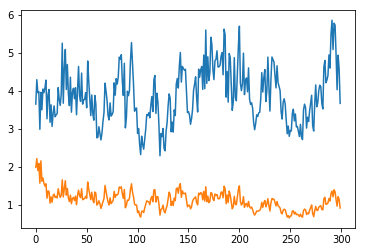

In [611]:
a1 = [samples[i][-1].a1 for i in range(len(samples))]
b1 = [samples[i][-1].b1 for i in range(len(samples))]
meanGen = [samples[i][-1].a1/samples[i][-1].b1 for i in range(len(samples))]
sdGen = [np.sqrt(samples[i][-1].a1)/samples[i][-1].b1 for i in range(len(samples))]
plt.plot(meanGen)
plt.plot(sdGen)

In [645]:
qs = scipy.stats.mstats.mquantiles(meanGen[150:],[0.025,0.975])
"Mean of GI: %.3f (%.3f - %.3f)"%(mean(meanGen[150:]),qs[0],qs[1])

'Mean of GI: 4.072 (2.814 - 5.691)'

## Posterior predictive checks

Below is a posterior predictive check for the empirical SD of the serial intervals.

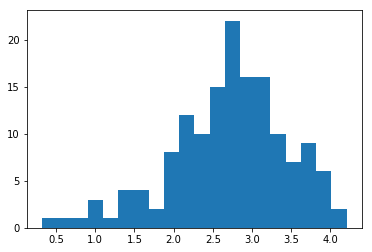

In [643]:
# Discretised distribution of incubation period
p = gamma.pdf(range(1,31),params.a2,scale=1/params.b2)
p = p/sum(p)

diff = []
for i in range(150,len(samples)):
    T = samples[i][0]
    realSerialInts = np.array([S[v]-S[T.parent[v]] for v in range(1,n+1)])
    I = samples[i][1]
    Srep = I + np.random.choice(range(1,31),size=len(I),p=p)
    replSerialInts = np.array([Srep[v]-Srep[T.parent[v]] for v in range(1,n+1)])
    diff.append(np.std(realSerialInts)-np.std(replSerialInts))
    
_ = plt.hist(diff,bins=20)

Below is a posterior predictive check for the proportion of negative serial intervals (pre-symptomatic transmissions).

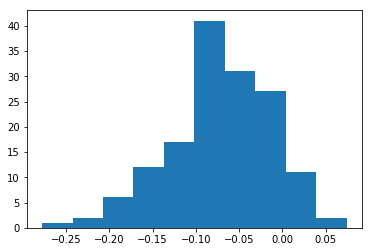

In [641]:
# Discretised distribution of incubation period
p = gamma.pdf(range(1,31),params.a2,scale=1/params.b2)
p = p/sum(p)

diff = []
for i in range(150,len(samples)):
    T = samples[i][0]
    realSerialInts = np.array([S[v]-S[T.parent[v]] for v in range(1,n+1)])
    I = samples[i][1]
    Srep = I + np.random.choice(range(1,31),size=len(I),p=p)
    replSerialInts = np.array([Srep[v]-Srep[T.parent[v]] for v in range(1,n+1)])
    diff.append(np.mean(realSerialInts<0)-np.mean(replSerialInts<0))
    
_ = plt.hist(diff,bins=10)